# Download dataset


In [1]:
project_name = '05-cifar10-cnn'

In [2]:
from torchvision.datasets.utils import download_url

dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

100%|██████████| 135M/135M [02:37<00:00, 858kB/s]  


In [3]:
import tarfile

with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
import os

data_dir = './data/cifar10'
print(os.listdir(data_dir))

classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


# Data augmentation

In [5]:
from torchvision import transforms as tt

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

valid_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

In [6]:
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(data_dir + '/train', train_transforms)
valid_ds = ImageFolder(data_dir + '/test', valid_transform)

In [7]:
batch_size = 100

In [8]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [9]:
import torch
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline

def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        plt.show()
        break

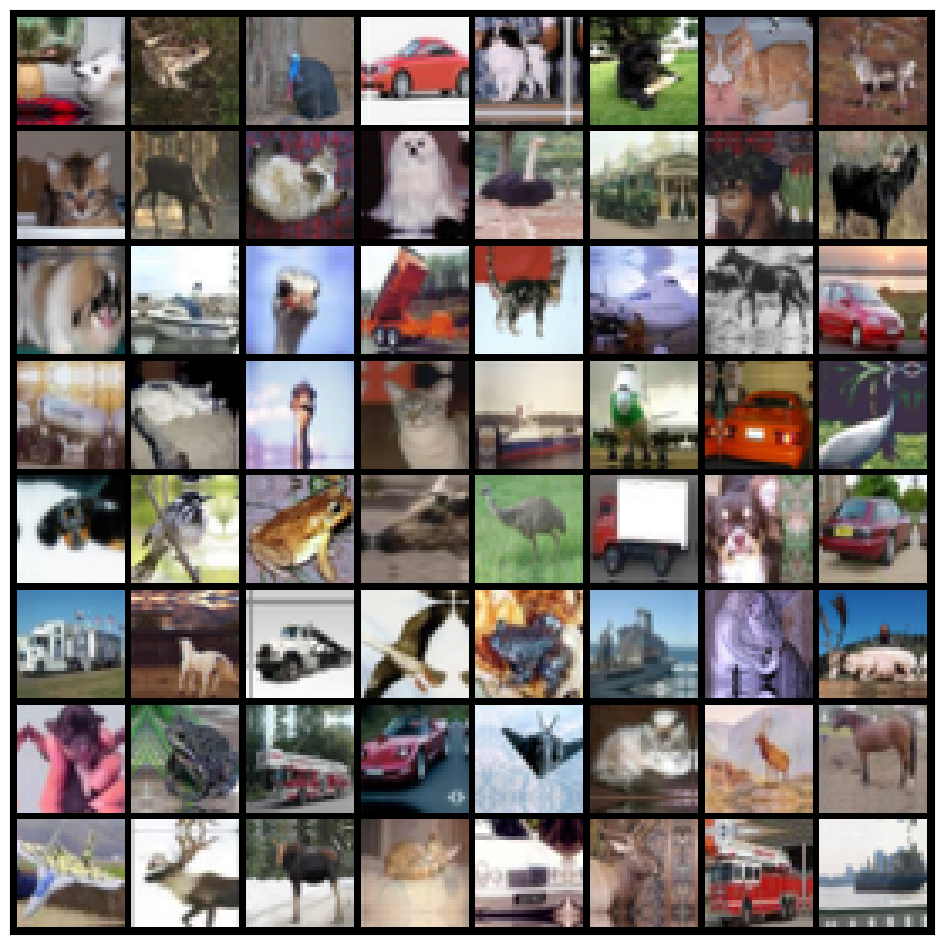

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cpu')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Model with ResNet and BatchNorm

In [14]:
from torch import nn

class SimpleResidualBlock(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # in residual block, dont change out_channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

In [15]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    print(out)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([100, 3, 32, 32])
tensor([[[[ 1.5163e+00,  1.5790e+00,  6.7963e-01,  ..., -6.0796e-01,
           -4.0577e-01, -4.5008e-01],
          [ 1.4830e+00,  9.4054e-01,  8.7345e-01,  ..., -7.7725e-01,
           -4.2967e-01, -5.1656e-01],
          [ 1.2037e+00,  1.3393e+00,  1.0941e+00,  ..., -3.8848e-01,
           -3.2623e-01, -4.6642e-01],
          ...,
          [-8.4636e-01, -7.5121e-01,  4.5931e-03,  ...,  6.3484e-01,
            4.7517e-01,  5.8113e-01],
          [-1.4446e+00, -4.3209e-01,  5.3769e-02,  ...,  7.5953e-01,
            6.4875e-01,  4.7867e-01],
          [-1.0333e+00, -5.8154e-02,  8.5430e-02,  ...,  5.5621e-01,
            3.2359e-01,  2.4605e-01]],

         [[ 1.0633e+00,  1.4173e+00,  7.3374e-01,  ..., -8.4491e-01,
           -6.0891e-01, -5.6957e-01],
          [ 1.1986e+00,  1.0455e+00,  1.2573e+00,  ..., -9.0884e-01,
           -6.6791e-01, -6.6791e-01],
          [ 9.6757e-01,  1.6120e+00,  1.6312e+00,  ..., -5.8896e-01,
           -5.6957e-01, -6.28

In [16]:
from torch.nn import functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassifierBase(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print('Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']
        ))

In [17]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]

    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(ImageClassifierBase):
    def __init__(self, in_channels, num_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.block1 = conv_block(in_channels, 64)
        self.block2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.block3 = conv_block(128, 256, pool=True)
        self.block4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Dropout(.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.res1(out) + out
        out = self.block3(out)
        out = self.block4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [18]:
model = to_device(Resnet9(3, 10), device)
model

Resnet9(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

# Training

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # setup custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # setup one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.305880546569824, 'val_acc': 0.09840000420808792}]

In [21]:
epochs = 8
max_lr = 1e-2
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [22]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00395, train_loss: 1.4275, val_loss: 1.3134, val_acc: 0.5733
Epoch [1], last_lr: 0.00936, train_loss: 1.0535, val_loss: 0.8006, val_acc: 0.7176
Epoch [2], last_lr: 0.00972, train_loss: 0.7838, val_loss: 0.8223, val_acc: 0.7376
Epoch [3], last_lr: 0.00812, train_loss: 0.6804, val_loss: 0.7308, val_acc: 0.7464
Epoch [4], last_lr: 0.00556, train_loss: 0.6017, val_loss: 0.5327, val_acc: 0.8167
Epoch [5], last_lr: 0.00283, train_loss: 0.4985, val_loss: 0.5154, val_acc: 0.8222
Epoch [6], last_lr: 0.00077, train_loss: 0.3697, val_loss: 0.3321, val_acc: 0.8893
Epoch [7], last_lr: 0.00000, train_loss: 0.2549, val_loss: 0.2822, val_acc: 0.9029


In [23]:
import numpy as np

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.show()

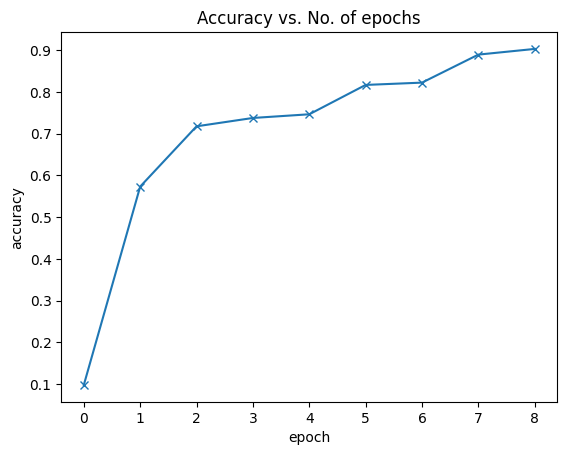

In [24]:
plot_accuracies(history)

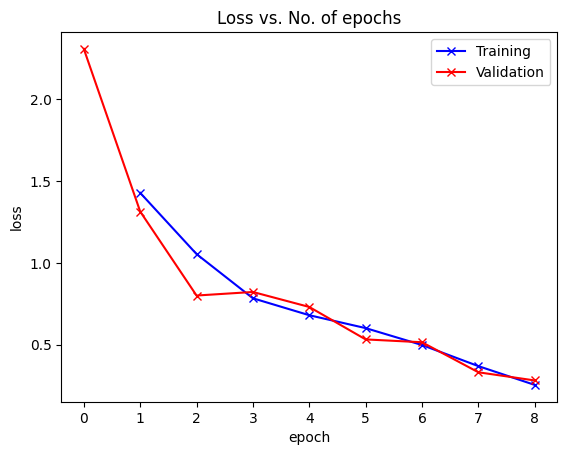

In [25]:
plot_losses(history)

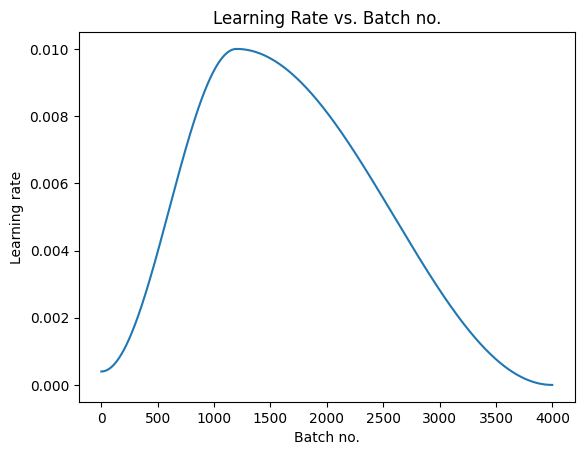

In [26]:
plot_lrs(history)